# **Classifying "Consumer Complaints Categories" with Doc2Vec and Logistic Regression**

## Doc2Vec

Doc2vec is an adaptation of Word2Vec that allows us to learn document similarity. 

Doc2vec model by itself is an unsupervised method.

Application: Topic modeling in NLP/Text Processing.

This notebook describes how the Doc2Vec model can ge trained based on both the available techniques -

**Distributed Bag of Words (DBoW) and Distributed Memory(DM)**.

Also, we find the document vectors from both the models (DBoW abd DM) and concatenate those vectors then train a Logistic Regression model to predict the categories based on the concatenated vector.

**Part 1: Implementation of Doc2Vec with DBoW and clasification with Logistic Regression**

**Part 2: Implementation of Doc2Vec with DM and clasification with Logistic Regression**

**Part 3: Concatenate the Doc2Vec documents vectors generated by DBoW and DM models and Clasification with Logistic Regression**


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Read Data from a CSV

In [ ]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Issue','Product']]
df = df[pd.notnull(df['Issue'])]
df.head(10)

,Issue,Product
0,Disclosure verification of debt,Debt collection
1,Disclosure verification of debt,Debt collection
2,Deposits and withdrawals,Bank account or service
3,Communication tactics,Debt collection
4,Incorrect information on credit report,Credit reporting
5,Cont'd attempts collect debt not owed,Debt collection
6,Managing the loan or lease,Consumer loan
7,False statements or representation,Debt collection
8,Managing the loan or lease,Consumer loan
9,Disclosure verification of debt,Debt collection


In [ ]:
df.shape

(99817, 2)

In [ ]:
df.isnull().sum()

Issue      0
Product    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


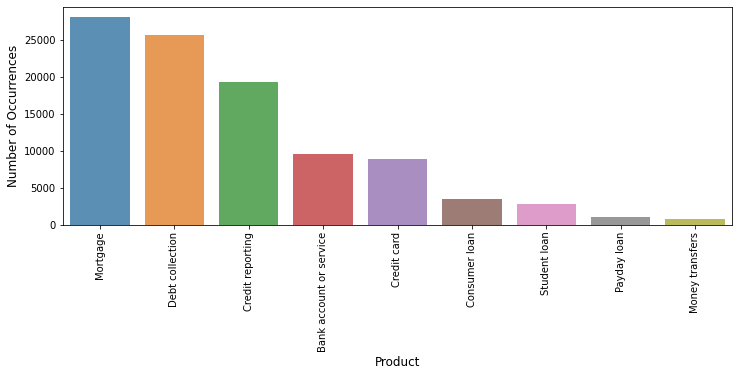

In [ ]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. 

However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

## Text Preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [ ]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [ ]:
df['Issue'] = df['Issue'].apply(cleanText)

In [ ]:

df['Issue'][1]

'disclosure verification of debt'

In [ ]:
df.shape

(99817, 2)

In [ ]:
df.index = range(99817)

In [ ]:
df.head(10)

,Issue,Product
0,disclosure verification of debt,Debt collection
1,disclosure verification of debt,Debt collection
2,deposits and withdrawals,Bank account or service
3,communication tactics,Debt collection
4,incorrect information on credit report,Credit reporting
5,cont'd attempts collect debt not owed,Debt collection
6,managing the loan or lease,Consumer loan
7,false statements or representation,Debt collection
8,managing the loan or lease,Consumer loan
9,disclosure verification of debt,Debt collection


In [ ]:
df.rename(columns = {'Issue':'issue'}, inplace = True)

In [ ]:
df.head()

,issue,Product
0,disclosure verification of debt,Debt collection
1,disclosure verification of debt,Debt collection
2,deposits and withdrawals,Bank account or service
3,communication tactics,Debt collection
4,incorrect information on credit report,Credit reporting


## Create Tagged Documents


Below, we define a function to label each complaint narrative/issue. 

And the TaggedDocument is an object-type to encapsulate a text-example function that helps to associate a tag/number with each document of the training corpus. 

In our case, the tag is simply the zero based line number

In [ ]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. 
    The format will be "TRAIN_i" or "TEST_i" where "i" is a dummy index of the complaint issue/narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.issue, df.Product, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
len(all_data)

99817

Let's take a look at the training corpus.

In [ ]:
all_data[:2]

[TaggedDocument(words=['incorrect', 'information', 'on', 'credit', 'report'], tags=['Train_0']),
 TaggedDocument(words=['deposits', 'and', 'withdrawals'], tags=['Train_1'])]


# Train a Doc2Vec Model

In the Word2Vec architecture, the two algorithm names are “Continuous Bag of Words” (CBoW) and “Skip-gram” (SG); in the Doc2Vec architecture, the corresponding algorithms are “Distributed Bag of Words” (DBoW) and “Distributed Memory” (DM).



# **PART 1: DBOW**

We'll instantiate a Doc2Vec model-Distributed Bag-of-Words (DBOW). 

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

**dm =0** means ‘distributed bag of words’ (DBOW)

**min_count=2** means ignoring all words with total frequency lower than this

**vector_size=100** is dimensionality of the generated feature vectors

**alpha=0.025** is the initial alpha rate, learning rate will linearly drop to min_alpha as training progresses. 

And then we build a vocabulary.

## Create the DBoW-Doc2Vec Model

In [ ]:
# Notice that dm is set to 0
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)

# Build the vocabulary
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 99817/99817 [00:00<00:00, 2158400.79it/s]


## Train the DBoW-Doc2Vec Model

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 99817/99817 [00:00<00:00, 2500942.89it/s]


CPU times: user 2min 33s, sys: 48 s, total: 3min 21s
Wall time: 2min 37s



## Custom Function to Generate the Document Vectors from the Trained Doc2Vec Model

Define a function to get the vectors.

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

Generate the document vectors from the Training and Test sets.

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

## Train a Logistic Regression Classifier to Classify the Categories

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Test the Logistic Regression Model on the Test Set

In [ ]:
logreg.score(test_vectors_dbow, y_test)

0.985273492286115

## Save the Doc2Vec Model

In [ ]:
model_dbow.save('d2v_model_dbow.doc2vec')

# **PART 2: Distributed Memory (DM)**

DM acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. 

While the word vectors represent the concept of a word, the **document vector intends to represent the concept of a document**.

We again instantiate a Doc2Vec model with a vector size with 100 words and iterating over the training corpus 30 times

## Create the DM-Doc2Vec Model

In [ ]:
# Notice, dm has been set to 1
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)

# Build the vocabulary
model_dm.build_vocab([x for x in tqdm(all_data)])


100%|██████████| 99817/99817 [00:00<00:00, 2100898.46it/s]


## Train the DM-Doc2Vec Model

In [ ]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 99817/99817 [00:00<00:00, 2509322.19it/s]


CPU times: user 5min 18s, sys: 2min 29s, total: 7min 48s
Wall time: 5min 53s


In [ ]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

## Train a Logistic Regression Classifier to Classify the Categories

In [ ]:
logreg.fit(train_vectors_dm, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logreg.score(test_vectors_dm, y_test)

0.8733386762839779

## Save the DM-Doc2Vec Model

In [ ]:
model_dm.save('d2v_model_dm.doc2vec')

#**Part3: Concatenated Document Vectors**

## Load the Pre-trained Models

In [ ]:
# model_dbow = Doc2Vec.load('d2v_model_dbow.doc2vec')
# model_dm = Doc2Vec.load('d2v_model_dm.doc2vec')
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Custom Function to Concatenate the Document Vectors

In [ ]:
def get_concat_vectors(model1, model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix], model2.docvecs[prefix])
    return vectors

In [ ]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test), 600, 'Test')

## Train a Logistic Regression Classifier to Classify the Categories

Now the LR model is trained on the concatenated document vectors from both DBoW and DM Doc2Vec models.

In [ ]:
%%time
logreg = LogisticRegression()
logreg.fit(train_vecs_dbow_dm, y_train)

CPU times: user 57.1 s, sys: 7.43 s, total: 1min 4s
Wall time: 33.1 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Test the LR Model

In [ ]:
logreg.score(test_vecs_dbow_dm, y_test)

0.9919187871502037